In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df = pd.read_csv ('judge_scores.csv')
sns.set(style="whitegrid", font_scale=1.2)

score_cols = [
    "belief_modeling",
    "perspective_taking",
    "consistency",
    "explanation_quality",
    "overall"
]

df = df.copy()
print("Models in dataset:", df["model"].unique())
print(df.shape)
df.head()
df.describe()
df.columns


Models in dataset: ['claude-4.5-sonnet' 'gemini-2.5-pro' 'gpt-5']
(600, 9)


Index(['scenario_id', 'variant', 'model', 'belief_modeling',
       'perspective_taking', 'consistency', 'explanation_quality', 'overall',
       'justification'],
      dtype='object')

In [ ]:
df[score_cols].describe()

,belief_modeling,perspective_taking,consistency,explanation_quality,overall
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,1.848333,2.078333,2.183333,1.620000,38.616667
std,0.826520,0.854448,0.965026,0.610646,12.797500
min,0.000000,0.000000,0.000000,0.000000,5.000000
25%,1.000000,1.000000,1.000000,1.000000,30.000000
50%,2.000000,2.000000,2.000000,2.000000,35.000000
75%,2.000000,3.000000,3.000000,2.000000,45.000000
max,4.000000,4.000000,5.000000,4.000000,80.000000


In [16]:
model_summary = (
    df.groupby("model")[score_cols]
      .agg(["mean", "std", "count"])
      .round(3)
)

model_summary
model_summary.to_csv("model_performance_summary.csv")

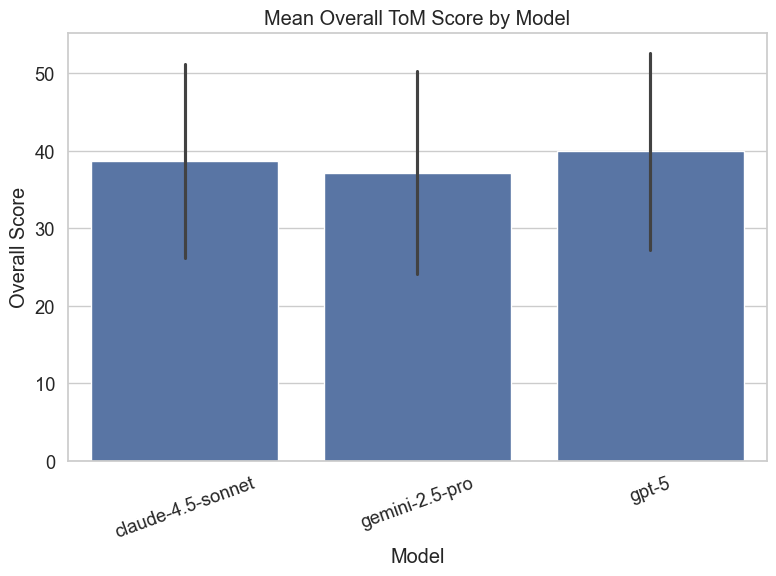

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=df,
    x="model",
    y="overall",
    estimator=np.mean,
    errorbar="sd"
)
plt.title("Mean Overall ToM Score by Model")
plt.ylabel("Overall Score")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
plt.savefig("figure1_overall_scores.pdf", bbox_inches="tight")

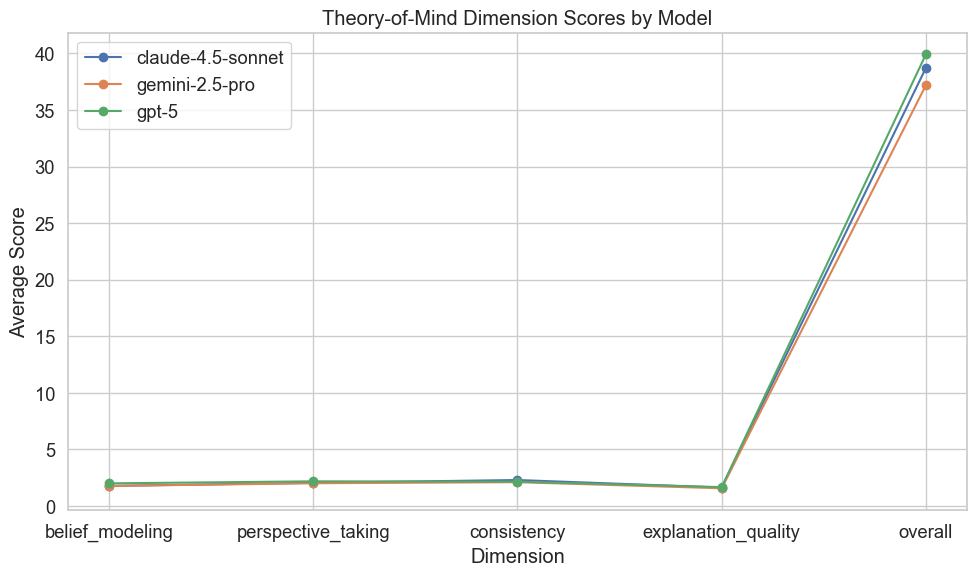

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(10,6))

model_dim_means = df.groupby("model")[score_cols].mean().T

for model in model_dim_means.columns:
    plt.plot(model_dim_means.index, model_dim_means[model], marker="o", label=model)

plt.title("Theory-of-Mind Dimension Scores by Model")
plt.ylabel("Average Score")
plt.xlabel("Dimension")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("figure2_dimension_scores.pdf", bbox_inches="tight")

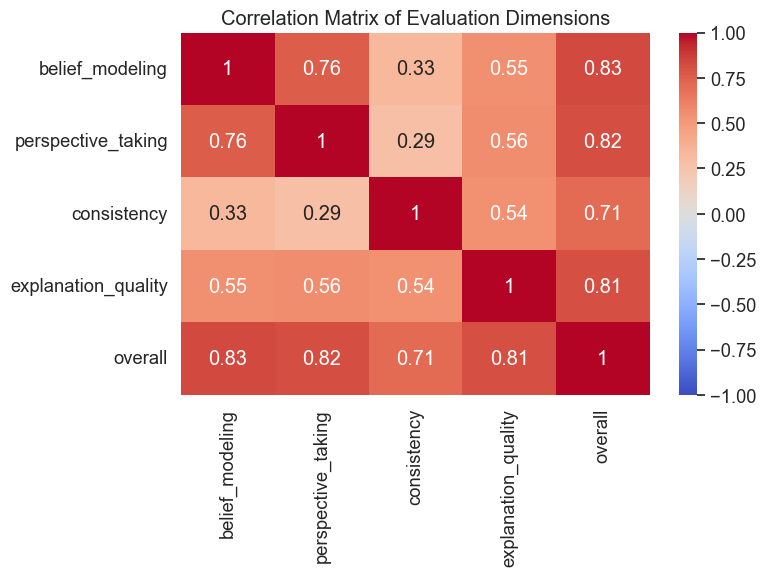

<Figure size 640x480 with 0 Axes>

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(df[score_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Evaluation Dimensions")
plt.tight_layout()
plt.show()
plt.savefig("figure3_correlation_matrix.pdf", bbox_inches="tight")

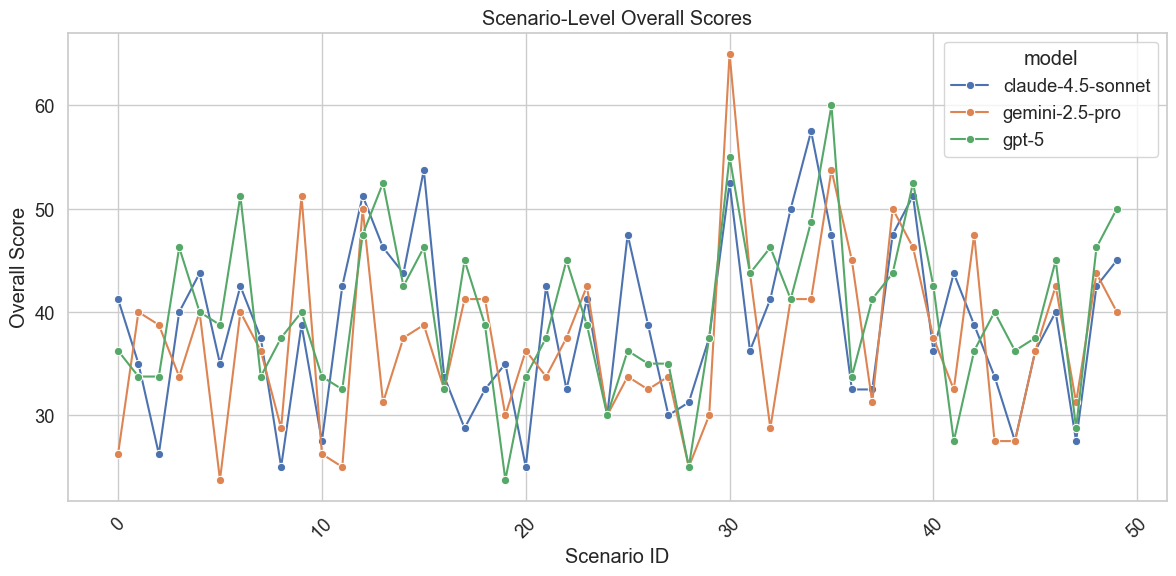

In [ ]:
scenario_summary = (
    df.groupby(["scenario_id", "model"])["overall"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=scenario_summary,
    x="scenario_id",
    y="overall",
    hue="model",
    marker="o"
)
plt.title("Scenario-Level Overall Scores")
plt.ylabel("Overall Score")
plt.xlabel("Scenario ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("figure4_scenario_overall.pdf", bbox_inches="tight")

In [21]:
examples = []

for m in df["model"].unique():
    sub = df[df["model"] == m].sort_values("overall")
    
    low = sub.head(1)[["model", "overall", "justification"]]
    high = sub.tail(1)[["model", "overall", "justification"]]
    
    print(f"\n=== LOW SCORE EXAMPLE: {m} ===")
    display(low)
    
    print(f"\n=== HIGH SCORE EXAMPLE: {m} ===")
    display(high)


=== LOW SCORE EXAMPLE: claude-4.5-sonnet ===


,model,overall,justification
376,claude-4.5-sonnet,15,Fails to model Team B: they value possession W...



=== HIGH SCORE EXAMPLE: claude-4.5-sonnet ===


,model,overall,justification
268,claude-4.5-sonnet,75,"Good ToM on B’s conservative, floor-first mind..."



=== LOW SCORE EXAMPLE: gemini-2.5-pro ===


,model,overall,justification
590,gemini-2.5-pro,5,"Ignores Team B’s conservative, floor-first pre..."



=== HIGH SCORE EXAMPLE: gemini-2.5-pro ===


,model,overall,justification
150,gemini-2.5-pro,80,Offer targets B’s upside preference with a dua...



=== LOW SCORE EXAMPLE: gpt-5 ===


,model,overall,justification
340,gpt-5,10,No evidence of Team B’s priorities or mindset....



=== HIGH SCORE EXAMPLE: gpt-5 ===


,model,overall,justification
471,gpt-5,75,Good recognition that B needs RB depth and bot...


In [22]:
X = df[["belief_modeling", "perspective_taking", "consistency", "explanation_quality"]]
X = sm.add_constant(X)
y = df["overall"]

reg = sm.OLS(y, X).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 7.366e+04
Date:                Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:32:22   Log-Likelihood:                -518.32
No. Observations:                 600   AIC:                             1047.
Df Residuals:                     595   BIC:                             1069.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0400    

In [23]:
best_by_scenario = (
    df.groupby(["scenario_id", "model"])["overall"]
      .mean()
      .reset_index()
      .sort_values(["scenario_id", "overall"], ascending=[True, False])
      .groupby("scenario_id")
      .head(1)
)

best_by_scenario["model"].value_counts(normalize=True).round(3)

model
gpt-5                0.40
claude-4.5-sonnet    0.36
gemini-2.5-pro       0.24
Name: proportion, dtype: float64